# Model Prototyping
<p style="font-size:20px">
After the creation of a <b>Feature_Engineered.csv</b> that contains clean data with predictability power and also being tested on a RandomForestClassifier, I am going to use multiple models and compare their performance.
</p>

## Importing Libraries

In [5]:
# Data Exploration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Basic Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

#Ensemble Models
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

# Boosting
from xgboost import XGBClassifier
from lightgbm import  LGBMClassifier

#Evaluation
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import f1_score, classification_report, confusion_matrix, roc_auc_score, precision_recall_curve

#PreProcessing
from  sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline 
import shap

c:\Users\Chr24\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
#List of Models
models = [
  ("Logistic Regression", LogisticRegression()),
  ("Decision Tree", DecisionTreeClassifier()),
  ("SVM", SVC(probability=True)),
  ("K Nearest Neighbour", KNeighborsClassifier()),
  ("Random Forest Classifier", RandomForestClassifier()),
  ("XGBoost",XGBClassifier()),
  ("LightGBM", LGBMClassifier())
]

In [7]:
#Evaluation function
def evaluate_model(models, X_train, y_train, X_test, y_test):
  results=[]
  scaler = StandardScaler()
  smote = SMOTE()
  for name, model in models:
    print(f"\n Name of Model: {name}")
    if name in ["Logistic Regression","SVM", "K Nearest Neighbour"]:
      X_train_scaled = scaler.fit_transform(X_train)
      X_test_scaled = scaler.transform(X_test)
      X_res, y_res = smote.fit_resample(X_train_scaled, y_train)
      model.fit(X_res,y_res)
      pred = model.predict(X_test_scaled)
    else:
      X_res, y_res = smote.fit_resample(X_train, y_train)
      model.fit(X_res, y_res)
      pred = model.predict(X_test)
    
    f1 = f1_score(y_test,pred)
    results.append((name,f1))
    print(classification_report(y_test, pred))
    

  return pd.DataFrame(results,columns=["Model","F1 Score"]).sort_values(by="F1 Score",ascending=False)

# Reading the file 

In [8]:
jee = pd.read_csv("../01_Data/02_Cleaned and Engineered/Feature_Engineered.csv", delimiter=",")
jee.head()

,peer_focused_mh,PSxIA,daily_study_hours,location_type,Income vs Admission,family_income,parental_support,dropout
0,0,0.00,5.4,2,0,0,1.62,1
1,1,1.65,5.5,2,1,1,1.65,0
2,3,0.00,7.0,1,0,0,2.70,1
3,3,2.49,2.1,1,3,0,0.83,0
4,4,9.16,6.3,1,4,1,2.29,0


# Creating X_train, X_test, y_train, y_test

In [6]:
jee.head()

,peer_focused_mh,PSxIA,daily_study_hours,location_type,Income vs Admission,family_income,parental_support,dropout
0,0,0.00,5.4,2,0,0,1.62,1
1,1,1.65,5.5,2,1,1,1.65,0
2,3,0.00,7.0,1,0,0,2.70,1
3,3,2.49,2.1,1,3,0,0.83,0
4,4,9.16,6.3,1,4,1,2.29,0


In [10]:
X = jee.drop(["dropout","Income vs Admission","PSxIA"], axis=1)
Y = jee['dropout']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify = Y)

# Evaluating the model with the Evaluation function described earlier

In [11]:
evaluate_model(models, X_train, y_train, X_test, y_test)    #Calling the evaluation function


 Name of Model: Logistic Regression
              precision    recall  f1-score   support

           0       0.97      0.77      0.86       793
           1       0.50      0.90      0.65       207

    accuracy                           0.80      1000
   macro avg       0.74      0.84      0.75      1000
weighted avg       0.87      0.80      0.81      1000


 Name of Model: Decision Tree
              precision    recall  f1-score   support

           0       0.91      0.85      0.88       793
           1       0.55      0.69      0.61       207

    accuracy                           0.82      1000
   macro avg       0.73      0.77      0.75      1000
weighted avg       0.84      0.82      0.83      1000


 Name of Model: SVM
              precision    recall  f1-score   support

           0       0.99      0.78      0.88       793
           1       0.54      0.98      0.70       207

    accuracy                           0.82      1000
   macro avg       0.77      0.88      

,Model,F1 Score
6,LightGBM,0.702403
2,SVM,0.697595
5,XGBoost,0.680934
3,K Nearest Neighbour,0.655039
0,Logistic Regression,0.645941
4,Random Forest Classifier,0.638554
1,Decision Tree,0.612069


<p style='font_size: 20px'>
It seems that ensemble models such as Random Forest Classifier, XG Boost and LightGBM are better suited for the JEE Dropout dataset and features
</p>

# Checking the Cross Validation scores of the top 3 models 

In [13]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)                     

for name, model in models:
  if name in ["Random Forest Classifier", "XGBoost", "LightGBM","SVM"]:
    print(f"\n Cross Validation for {name}")
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring="f1")
    print(f"F1 score: {scores.mean():.4f} (+/- {scores.std():.4f})")


 Cross Validation for SVM
F1 score: 0.6362 (+/- 0.0048)

 Cross Validation for Random Forest Classifier
F1 score: 0.6069 (+/- 0.0216)

 Cross Validation for XGBoost
F1 score: 0.5931 (+/- 0.0189)

 Cross Validation for LightGBM
[LightGBM] [Info] Number of positive: 663, number of negative: 2537
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 363
[LightGBM] [Info] Number of data points in the train set: 3200, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207187 -> initscore=-1.341963
[LightGBM] [Info] Start training from score -1.341963
[LightGBM] [Info] Number of positive: 663, number of negative: 2537
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 363
[LightGBM] [Info] Num

# Hyper Parameter tuning 
<p style='font-size:20px'>
for finding the best conditions for the top 3 models to find the best model performance
</p>

## Random Forest Classifier

In [16]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}
cv = StratifiedKFold(n_splits = 5, shuffle=True, random_state=42)
grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, scoring='f1', cv=cv, n_jobs=-1, verbose=2)

grid_search_rf.fit(X_train, y_train)

print("Best params:", grid_search_rf.best_params_)
print("Best F1 Score:", grid_search_rf.best_score_)




Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best params: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
Best F1 Score: 0.6245018582126522


## XG Boost

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search_rf = GridSearchCV(XGBClassifier(random_state=42), param_grid, scoring='f1', cv=3, n_jobs=-1, verbose=1)

grid_search_rf.fit(X_train, y_train)

print("Best params:", grid_search_rf.best_params_)
print("Best F1 Score:", grid_search_rf.best_score_)


Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best F1 Score: 0.5910025318492284


c:\Users\Chr24\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:44:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


## Light GBM

In [19]:
from sklearn.model_selection import RandomizedSearchCV

random_search_rf = RandomizedSearchCV(
    LGBMClassifier(random_state=42),
    param_distributions=param_grid,
    n_iter=100,  # try 100 random combos instead of 5184
    scoring='f1',
    cv=3,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

random_search_rf.fit(X_train, y_train)

print("Best params:", random_search_rf.best_params_)
print("Best F1 Score:", random_search_rf.best_score_)



Fitting 3 folds for each of 100 candidates, totalling 300 fits
[LightGBM] [Info] Number of positive: 829, number of negative: 3171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 366
[LightGBM] [Info] Number of data points in the train set: 4000, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

## SVC


In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
param_grid = {
    'C' : [0.1, 1, 10, 100],
    'gamma' : ['scale', 'auto', 0.01, 0.1, 1],
    'kernel' : ['linear', 'rbf'],
    'class_weight' : [None, 'balanced']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=SVC(),
    param_grid = param_grid,
    scoring='f1',
    cv=cv,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train,y_train)

print ("Best Params: ", grid_search.best_params_)
print("BEST CV F1 Score : ",grid_search.best_score_)

Fitting 5 folds for each of 80 candidates, totalling 400 fits
Best Params:  {'C': 10, 'class_weight': 'balanced', 'gamma': 'auto', 'kernel': 'rbf'}
BEST CV F1 Score :  0.7141814901408683


## Shap 
<p style='font-size:20px'>
for Feature importance
</p>

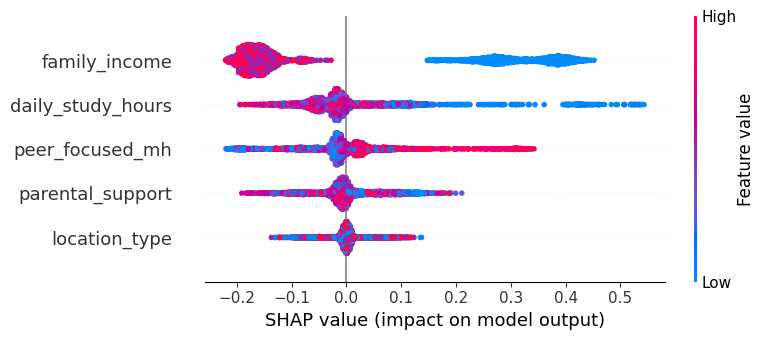

In [22]:
import shap

# Fit model
rf_model = RandomForestClassifier().fit(X_train, y_train)
# Explain predictions
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_train)
# Plot
shap.summary_plot(shap_values[...,1], X_train)  # class 1


# Voting Classifier combining RandomForestClassifier and SVC
<p style='font-size:20px'>
comparing Voting Classifier with Random Forest Classifier which currently is the best performing model
</p>

In [17]:
rmodel = RandomForestClassifier().fit(X_train, y_train)
predr = rmodel.predict(X_test)
print(classification_report(y_test, predr))

voting_clf = VotingClassifier(estimators=[
  ('rfc', RandomForestClassifier(random_state=42)),
  ('svc', SVC(random_state=42, probability=True))
], voting='soft')

voting_clf.fit(X_train, y_train)
pred = voting_clf.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.89      0.88      0.89       793
           1       0.56      0.58      0.57       207

    accuracy                           0.82      1000
   macro avg       0.73      0.73      0.73      1000
weighted avg       0.82      0.82      0.82      1000

              precision    recall  f1-score   support

           0       0.91      0.89      0.90       793
           1       0.60      0.64      0.62       207

    accuracy                           0.84      1000
   macro avg       0.75      0.77      0.76      1000
weighted avg       0.84      0.84      0.84      1000



In [18]:
from sklearn.model_selection import GridSearchCV

voting_clf = VotingClassifier(estimators=[
  ('rfc', RandomForestClassifier(random_state=42)),
  ('svc', SVC(random_state=42, probability=True))
], voting='soft')

param_grid = {
    'rfc__n_estimators': [100, 200],
    'rfc__max_depth': [None, 10, 20],
    'svc__C': [0.1, 1, 10],
    'svc__kernel': ['linear', 'rbf'],
    'weights': [(1,1), (2,1), (1,2)]
}

grid = GridSearchCV(voting_clf, param_grid, cv=5, scoring='f1')
grid.fit(X_train, y_train)

print(grid.best_params_)
print(grid.best_score_)

{'rfc__max_depth': 10, 'rfc__n_estimators': 100, 'svc__C': 1, 'svc__kernel': 'rbf', 'weights': (1, 1)}
0.6246051460452698


## Cross Validation Score of the Voting Classifier

In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(voting_clf, X_train, y_train, cv=5, scoring='f1')
print(f"Cross-validated F1: {scores.mean():.4f} (+/- {scores.std():.4f})")

[LightGBM] [Info] Number of positive: 663, number of negative: 2537
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000272 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 363
[LightGBM] [Info] Number of data points in the train set: 3200, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207187 -> initscore=-1.341963
[LightGBM] [Info] Start training from score -1.341963
[LightGBM] [Info] Number of positive: 663, number of negative: 2537
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 365
[LightGBM] [Info] Number of data points in the train set: 3200, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207187 -> initscore=-1.341963
[LightGBM] [Info] Start training from score -1.341963
[LightGBM] [Info] Number

<p style='font-size: 25px'>
From all the Prototype models used on the data, we saw that <b>Ensemble models such as RandomForestClassifier, XG Boost Classifier and Light GBM Classifier</b> performed best. After comparing Random Forest Classifier, the best performing model, with the Voting Classifier which combined the 3 ensemble models said, I concluded that <b style='font-size: 27px'>Random Forest Classifier</b> is the best model to go forward with due to its <b>easy interpretability, use and faster speed</b>.
</p>